In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels
from statsmodels.tsa.stattools import coint

In [2]:
#set RNG seed
np.random.seed(107)

In [3]:
# Graph setup (not important for functionality)
sns.set_style('whitegrid')
pd.plotting.register_matplotlib_converters()

In [4]:
#read csvs
cad_jpy = pd.read_csv("cadjpy_intraday-60min_historical-data-03-02-2020.csv",index_col='Time',parse_dates=True)[:-1]

coil = pd.read_csv("clj20_intraday-60min_historical-data-03-02-2020.csv",index_col='Time',parse_dates=True)[:-1]

In [5]:
#inner merge on time
df_combine = pd.merge(cad_jpy, coil, on = "Time")
df_combine.sort_index(inplace=True)

In [6]:
#split into training and testing sets
df_train = df_combine.loc['2019-03-01':'2020-01-01']
df_test = df_combine.loc["2020-01-01":]


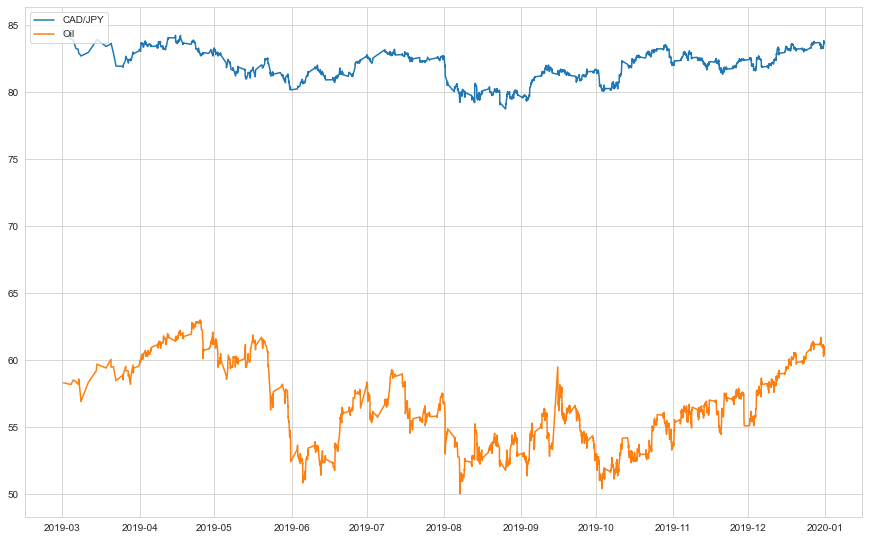

In [7]:
#plot the two timeseries
plt.figure(figsize=(15, 15 / 1.6))

plt.plot(df_train.index, df_train['Open_x'], label='CAD/JPY')
plt.plot(df_train.index, df_train['Open_y'], label='Oil')
plt.legend(loc='upper left')
plt.show()

In [8]:
# compute the p-value of the cointegration test
# will inform us as to whether the ratio between the 2 timeseries is stationary around its mean
score, pvalue, _ = coint(df_train['Open_x'],df_train['Open_y'])
pvalue

0.055138623468645294

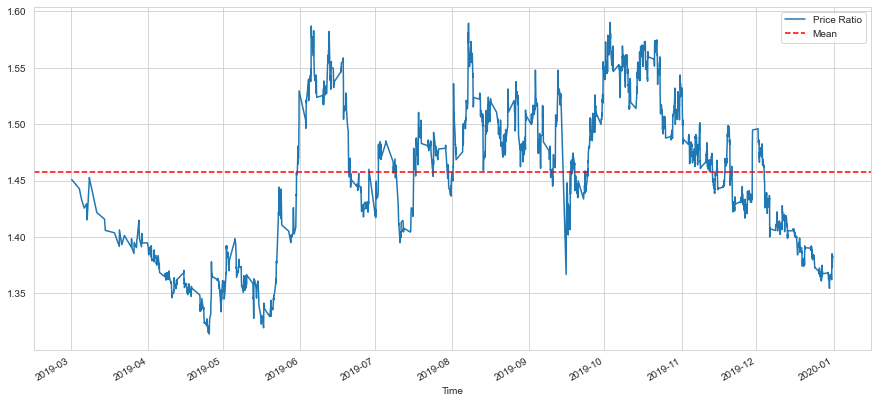

In [9]:
#plot of whether the price ratio is mean reverting about the mean
(df_train['Open_x']/df_train['Open_y']).plot(figsize=(15,7)) 
plt.axhline((df_train['Open_x']/df_train['Open_y']).mean(), color='red', linestyle='--') 
plt.xlabel('Time')
plt.legend(['Price Ratio', 'Mean'])
plt.show()

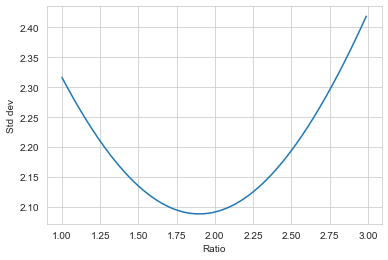

In [10]:
#compute the hedge ratio
#we will choose hedge ratio that minimized std
ratios = np.arange(1, 3, .01)

std_dev = []

for ratio in ratios:
    result = (ratio * df_train['Open_x'] - df_train['Open_y']).std()
    
    std_dev.append(result)
   
# viewing our standard deviation as a function of ratio
plt.ylabel("Std dev")
plt.xlabel("Ratio")
plt.plot(ratios, std_dev)
plt.show()

# use hedge ratio of 1.8

In [11]:
#pd.options.mode.chained_assignment = None  # default='warn'

<ipython-input-12-75dd86754e02>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Spread'] = df_train['Open_x'] * 1.8 - df_train['Open_y']


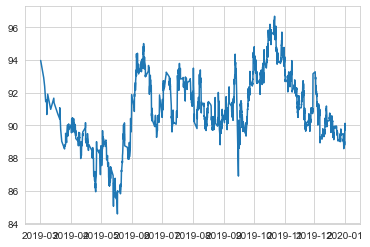

In [12]:
#compute the timeseries of spread using our chosen hedge ratio
#and plot it
df_train['Spread'] = df_train['Open_x'] * 1.8 - df_train['Open_y']
plt.plot(df_train['Spread'])

In [13]:
# Import numba -- a library to help things execute faster
from numba import jit

# Compute the EWMA of the series
# 1. Understand the theory behind this indicator
# 2. Understand how this algorithm computes the indicator
# 3. Understand why/how it's robust to gaps in the time series (unlike the built-in NumPy version)
# 4. Experiment with adding/removing the @jit annotation, and see how it affects performance

@jit(nopython = True)
def compute_ewma_helper(scaled_timedeltas, data):
    # Initialiaze an empty array of the same size as the data series, and fill in the first element
    ewma = np.empty(len(data))
    ewma[0] = data[0]
    
    # For every other row in the empty array, use the recursive formula...
    for row_index in range(1, len(data)):
        
        # Compute the multiplier we talked about on the board
        multiplier = np.exp(-scaled_timedeltas[row_index - 1])
        
        # Compute the ewma here using the recursive formula
        ewma[row_index] = (1 - multiplier) * data[row_index] + multiplier * ewma[row_index - 1]
    
    return ewma

def compute_ewma(data_series, window):
    deltat_over_window = np.diff(data_series.index.values) / window
    data = data_series.values
    
    return compute_ewma_helper(deltat_over_window, data)

In [14]:
# Compute the 12 hour EWMA of the price series
ewma_12 = compute_ewma(df_train['Spread'], np.timedelta64('12', 'h'))

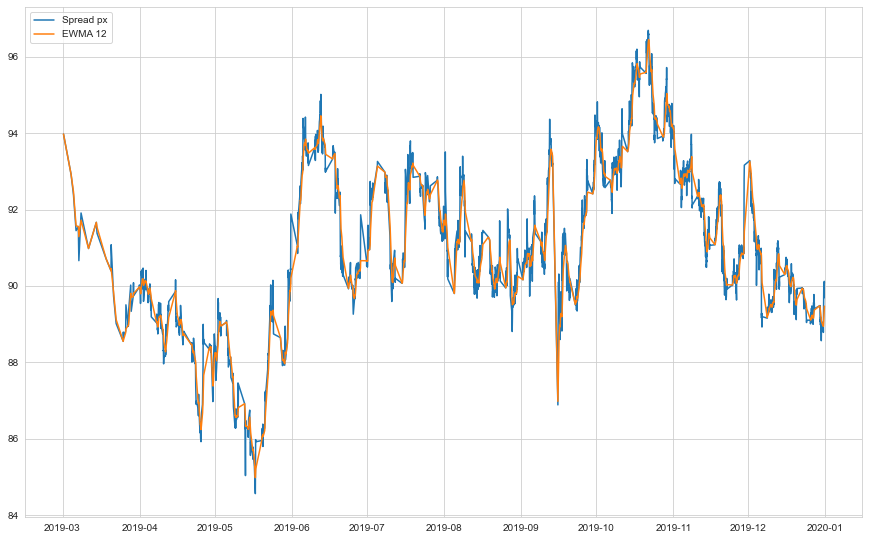

In [15]:
# Plot the spread with ewma overlaid
plt.figure(figsize=(15, 15 / 1.6))

plt.plot(df_train.index, df_train['Spread'], label='Spread px')
plt.plot(df_train.index, ewma_12, label='EWMA 12')
plt.legend(loc='upper left')
plt.show()

In [16]:
# This is a quick, small backtester. Not important to understand every detail, but a worthwhile exercise
import numba

def compute_pnl(prices, positions):
    '''
    This function computes our PnL over every point in the backtesting window. 
    Input: 
    prices - an array of price data over time
    positions - an array of positions (e.g. 1 for long 1, -2 for short 2) we are taking in the asset over time
    Returns: 
    pnl_array - the array of our PnL over time
    m2m_pnl - the array of our direct PnL + value of our positions over time
    '''
    
    pnl_array = np.empty(len(prices))
    pnl_array[0] = 0
    
    for i in range(1 , len(prices)):
        delta_pos = positions[i] - positions[i - 1]
        
        pnl_array[i] = pnl_array[i - 1] - prices[i] * delta_pos
    
    m2m_pnl = pnl_array + prices * positions
    
    return pnl_array, m2m_pnl
        

def backtest_strategy(prices, normalizer, lots_per_norm, period_size):
    '''
    This function is a wrapper that computes our PnLs from our strategy
    Inputs:
    prices - array of price data
    normalizer - a parameter of our strategy (determines our overboughtness ratio)
    lots_per_norm - a parameter of our strategy (a multiplier to determine the size of our positions)
    period_size - a parameter of our strategy (affects our ewma calculation)
    Returns:
    a dataframe with the positions and PnLs of our backtest
    '''
    
    # This is specific to our strategy:
    # A. Compute the MACD, signal line, and the difference between them
    ave = compute_ewma(prices, period_size)
    diff = prices - ave
    
    # B. Determine positions. If the value is high in one direction, that indicates that BTC is overbought (why? Intuition?)
    #    Depending on how overbought/oversold it is, we sell/buy against the market.
    positions = -np.round(diff / normalizer) * lots_per_norm
    
    # C. Compute the PnL associated with these price and position series
    pnls, m2m_pnl = compute_pnl(prices.values, positions)
    
    # Return a DataFrame containing all the things  
    return pd.DataFrame(np.array([positions, pnls, m2m_pnl]).T, index=prices.index, columns=["Pos", "PnL", "PnL M2M"])

In [17]:
# This is just a quick helper to make backtesting on the training data easier.
def get_train_backtest(spread, normalizer, period):
    return backtest_strategy(spread, normalizer, 1, period)

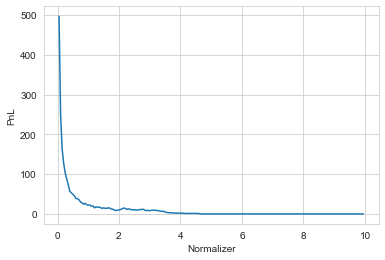

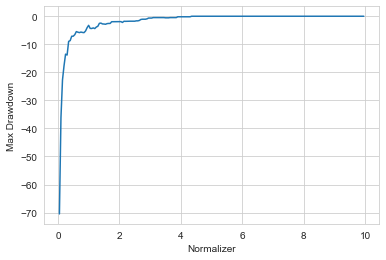

<ipython-input-18-1c0c24a04206>:30: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(normalizers, -np.array(end_pnls) / max_drawdowns)
<ipython-input-18-1c0c24a04206>:30: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(normalizers, -np.array(end_pnls) / max_drawdowns)


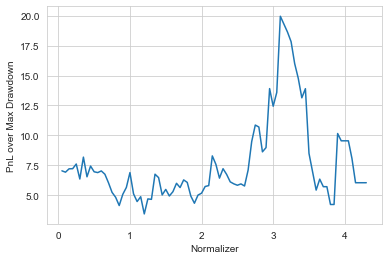

In [18]:
#we perform the optimization on the normalizer parameter:
normalizers = np.arange(0.05, 10, .05)

end_pnls = []
max_drawdowns = []

for normalizer in normalizers:
# For every potential value of the parameter
    # Run a backtest with that value
    result = get_train_backtest(df_train['Spread'],normalizer, np.timedelta64('30', 'h'))
    
    end_pnls.append(result['PnL M2M'].iloc[-1])
    max_drawdowns.append(-max(result['PnL M2M'].cummax() - result['PnL M2M']))

# viewing our end PnL as a function of period_size
plt.ylabel("PnL")
plt.xlabel("Normalizer")
plt.plot(normalizers, end_pnls)
plt.show()

# viewing our max drawdown as a function of period_size
plt.ylabel("Max Drawdown")
plt.xlabel("Normalizer")
plt.plot(normalizers, max_drawdowns)
plt.show()

# viewing our Total PnL / Max Drawdown as a function of period_size
plt.ylabel("PnL over Max Drawdown")
plt.xlabel("Normalizer")
plt.plot(normalizers, -np.array(end_pnls) / max_drawdowns)
plt.show()

# choose 0.5

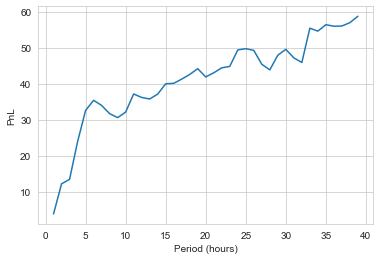

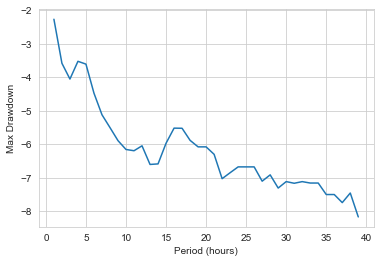

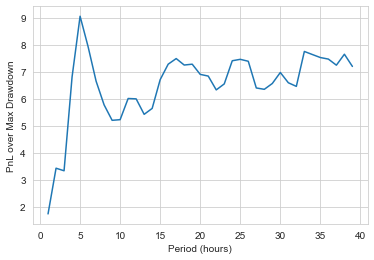

In [19]:
#we then perform this optimization on the period_size parameter:
period_range = np.arange(1, 40, 1) * np.timedelta64('1', 'h')

end_pnls = []
max_drawdowns = []

for period in period_range:
# For every potential value of the parameter
    # Run a backtest with that value
    result = get_train_backtest(df_train['Spread'],0.5, period)
    
    end_pnls.append(result['PnL M2M'].iloc[-1])
    max_drawdowns.append(-max(result['PnL M2M'].cummax() - result['PnL M2M']))

# viewing our end PnL as a function of period_size
plt.ylabel("PnL")
plt.xlabel("Period (hours)")
plt.plot(period_range, end_pnls)
plt.show()

# viewing our max drawdown as a function of period_size
plt.ylabel("Max Drawdown")
plt.xlabel("Period (hours)")
plt.plot(period_range, max_drawdowns)
plt.show()

# viewing our Total PnL / Max Drawdown as a function of period_size
plt.ylabel("PnL over Max Drawdown")
plt.xlabel("Period (hours)")
plt.plot(period_range, -np.array(end_pnls) / max_drawdowns)
plt.show()

# choosing 25 hours

<ipython-input-20-01fbb58e74ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Spread'] = df_test['Open_x'] * 1.8 - df_test['Open_y']


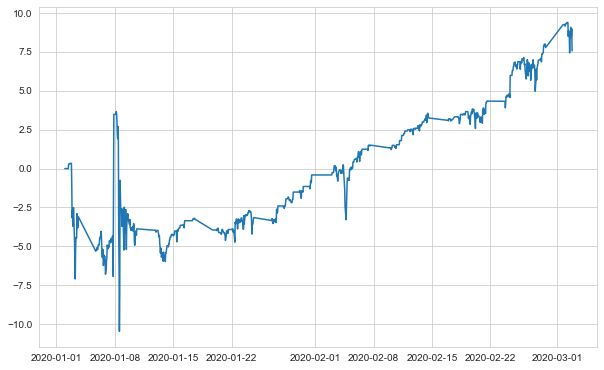

In [20]:
# Well, let's take a look at how it performs on our testing data...

df_test['Spread'] = df_test['Open_x'] * 1.8 - df_test['Open_y']

results = backtest_strategy(df_test['Spread'], 0.5, 1, np.timedelta64('25', 'h'))
plt.figure(figsize=(10, 10 / 1.6))
plt.plot(results['PnL M2M'])
plt.show()

In [21]:
#computes some metrics for our strategy's performance
max_drawdown_test = min(results['PnL M2M'] - results['PnL M2M'].cummax())
pnl_test = results['PnL M2M'].iloc[-1]
num_trades = (results['Pos'].diff() != 0).sum()

print("Final PnL: {}".format(pnl_test))
print("Max Drawdown: {}".format(max_drawdown_test))
print("PnL / Max Drawdown: {}".format(-pnl_test / max_drawdown_test))
print("# trades: {}".format(num_trades))

Final PnL: 7.560799999999745
Max Drawdown: -14.119600000000176
PnL / Max Drawdown: 0.5354825915748074
# trades: 332


Hence we observe that this simplistic strategy provides too low of a PnL even before considering transaction costs,
which is expected since it is a well-known strategy.